# Import and Setup

In [57]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import pandas as pd

from gpytorch.models import ExactGP
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel
from gpytorch.means import LinearMean
from gpytorch.distributions import MultivariateNormal
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.priors import NormalPrior, GammaPrior

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Load and Prepare Data

In [69]:
# Load dataset
df = pd.read_csv('PowerLaw/btc_data_bitinfocharts.csv')
filtered_df = df.dropna()

# Extract columns
log_days = filtered_df['log_days_since_genesis'].values.reshape(-1, 1)
log_prices = filtered_df['log_price_BTC'].values


# Downsample Data

In [70]:
num_bins = 100
points_per_bin = 10
bins = np.linspace(log_days.min(), log_days.max(), num_bins)

downsampled_log_days, downsampled_log_prices = [], []

for i in range(len(bins) - 1):
    mask = (log_days.flatten() >= bins[i]) & (log_days.flatten() < bins[i + 1])
    indices = np.where(mask)[0]
    if len(indices) > 0:
        sampled_indices = np.random.choice(indices, min(points_per_bin, len(indices)), replace=False)
        downsampled_log_days.extend(log_days[sampled_indices].flatten())
        downsampled_log_prices.extend(log_prices[sampled_indices])

# Convert to numpy arrays and sort
downsampled_log_days = np.array(downsampled_log_days).reshape(-1, 1)
downsampled_log_prices = np.array(downsampled_log_prices)
sorted_indices = np.argsort(downsampled_log_days.flatten())
downsampled_log_days = downsampled_log_days[sorted_indices]
downsampled_log_prices = downsampled_log_prices[sorted_indices]


# Standardise the Data

In [71]:
x = np.log10(np.exp(downsampled_log_days))
y = np.log10(np.exp(downsampled_log_prices))

x = torch.tensor(x.flatten(), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

x_mean, x_std = x.mean(), x.std()
y_mean, y_std = y.mean(), y.std()

x_standardized = (x - x_mean) / x_std
y_standardized = (y - y_mean) / y_std


# Train-Test Split

In [80]:
n_train = 400  # Number of training points
x_train, y_train = x_standardized[:n_train], y_standardized[:n_train]
x_test, y_true = x_standardized[n_train:], y_standardized[n_train:]


# OLS Regression

In [73]:
import statsmodels.api as sm

# Ensure x_train and y_train are properly defined
x_train_np = x_standardized[:n_train].numpy()  # Convert torch tensor to numpy
y_train_np = y_standardized[:n_train].numpy()

# Perform OLS regression using statsmodels
X_train = sm.add_constant(x_train_np)  # Add intercept term
ols_model = sm.OLS(y_train_np, X_train).fit()

# Extract OLS coefficients
ols_intercept = ols_model.params[0]  # Intercept
ols_gradient = ols_model.params[1]  # Slope

# Compute R-squared
r_squared = ols_model.rsquared

# Print results
print("\nOLS Regression Results:")
print(f"OLS Gradient: {ols_gradient:.3f}")
print(f"OLS Intercept: {ols_intercept:.3f}")
print(f"R-squared: {r_squared:.3f}")



OLS Regression Results:
OLS Gradient: 1.107
OLS Intercept: 0.119
R-squared: 0.907


# Define GP Model

In [81]:
class GPModel(ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = LinearMean(input_size=1)
        self.mean_module.weights = torch.nn.Parameter(torch.tensor([ols_gradient], dtype=torch.float32))
        self.mean_module.bias = torch.nn.Parameter(torch.tensor([ols_intercept], dtype=torch.float32))

        
        base_kernel = PeriodicKernel(
            lengthscale_prior=GammaPrior(15.0, 2.0),
            period_length_prior=NormalPrior(1.0, 0.05)
        )
        self.covar_module = ScaleKernel(base_kernel)
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)


# Initialise Model and Likelihood

In [82]:
likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.Interval(1e-6, 1e-1))
likelihood.noise.prior = GammaPrior(2.0, 0.1)

model = GPModel(x_train, y_train, likelihood)


# Generate and Plot Prior Samples

/Users/nicolasanguita/miniforge3/envs/power-law-env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
/Users/nicolasanguita/miniforge3/envs/power-law-env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-05 to the diagonal
  warnings.warn(
/Users/nicolasanguita/miniforge3/envs/power-law-env/lib/python3.10/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(


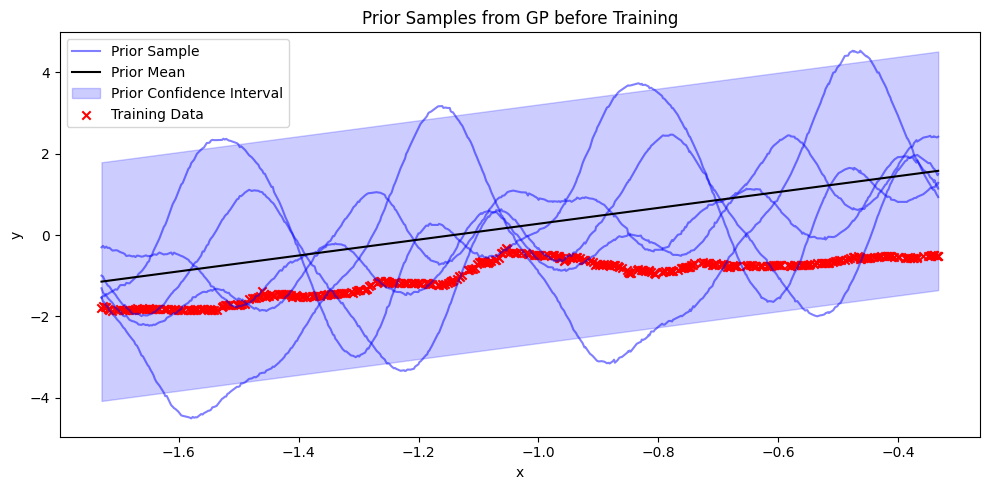

In [83]:
with torch.no_grad():
    prior_dist = model(x_train)  # Compute prior distribution ONLY on training data
    prior_samples = prior_dist.sample(torch.Size([5]))  # Sample 5 functions from the prior
    prior_mean = prior_dist.mean
    prior_lower, prior_upper = prior_dist.confidence_region()

    # Unstandardize the prior samples and statistics
    prior_samples = prior_samples * y_std + y_mean
    prior_mean = prior_mean * y_std + y_mean
    prior_lower = prior_lower * y_std + y_mean
    prior_upper = prior_upper * y_std + y_mean

# Plot prior samples
plt.figure(figsize=(10, 5))
for i in range(5):
    plt.plot(x_train.numpy(), prior_samples[i].numpy(), 'b-', alpha=0.5, label='Prior Sample' if i == 0 else "")
plt.plot(x_train.numpy(), prior_mean.numpy(), 'k-', label='Prior Mean')
plt.fill_between(x_train.numpy(), prior_lower.numpy(), prior_upper.numpy(), color='b', alpha=0.2, label='Prior Confidence Interval')
plt.scatter(x_train.numpy(), y_train.numpy(), c='r', marker='x', label='Training Data')
# plt.scatter(x[:n_train].numpy(), y[:n_train].numpy(), c='r', marker='x', label='Training Data')
plt.title('Prior Samples from GP before Training')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.tight_layout()
plt.show()


# Train the Model

In [85]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
mll = ExactMarginalLogLikelihood(likelihood, model)

best_loss = float('inf')
patience, patience_counter = 30, 0

for i in range(300):
    optimizer.zero_grad()
    output = model(x_train)
    loss = -mll(output, y_train)
    loss.backward()
    optimizer.step()
    
    if loss.item() < best_loss:
        best_loss = loss.item()
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping at epoch {i+1}')
            model.load_state_dict(best_model_state)
            break


Early stopping at epoch 181


# Generate Predictions

In [86]:
model.eval()
likelihood.eval()

with torch.no_grad():
    posterior = model(x_standardized)
    mean_full = posterior.mean * y_std + y_mean
    lower_full, upper_full = posterior.confidence_region()
    
    # Apply standardization back
    lower_full = lower_full * y_std + y_mean
    upper_full = upper_full * y_std + y_mean

    # Obtain posterior samples
    posterior_samples = posterior.sample(torch.Size([5])) * y_std + y_mean

# Plot Results

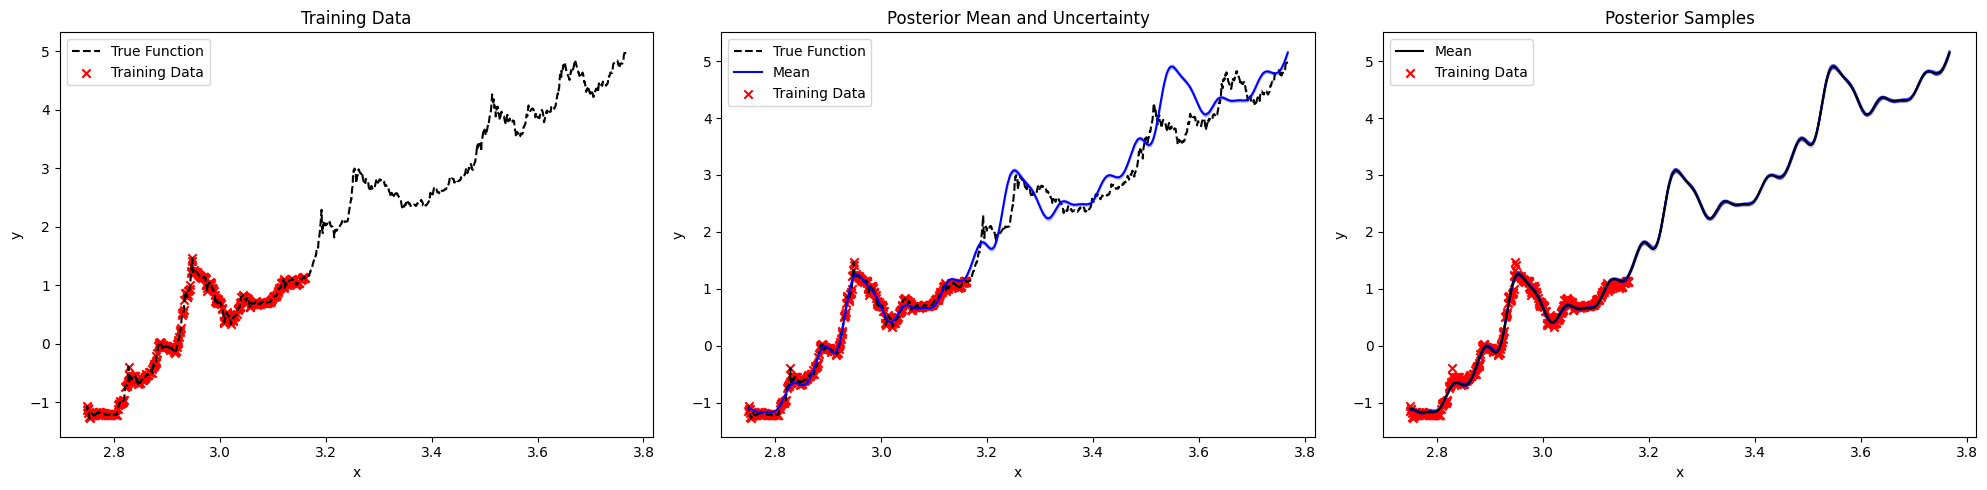

In [87]:
plt.figure(figsize=(20, 5))

# Training Data
plt.subplot(131)
plt.plot(x.numpy(), y.numpy(), 'k--', label='True Function')
plt.scatter(x[:n_train].numpy(), y[:n_train].numpy(), c='r', marker='x', label='Training Data')
plt.title('Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Posterior Mean and Uncertainty
plt.subplot(132)
plt.plot(x.numpy(), y.numpy(), 'k--', label='True Function')
plt.plot(x.numpy(), mean_full.numpy(), 'b-', label='Mean')
plt.fill_between(x.numpy(), lower_full.numpy(), upper_full.numpy(), color='b', alpha=0.2)
plt.scatter(x[:n_train].numpy(), y[:n_train].numpy(), c='r', marker='x', label='Training Data')
plt.title('Posterior Mean and Uncertainty')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# Posterior Samples
plt.subplot(133)
for i in range(5):
    plt.plot(x.numpy(), posterior_samples[i].numpy(), 'b-', alpha=0.5)
plt.plot(x.numpy(), mean_full.numpy(), 'k-', label='Mean')
plt.fill_between(x.numpy(), lower_full.numpy(), upper_full.numpy(), color='b', alpha=0.2)
plt.scatter(x[:n_train].numpy(), y[:n_train].numpy(), c='r', marker='x', label='Training Data')
plt.title('Posterior Samples')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

plt.tight_layout()
plt.show()


# Plot number of SDs from GP's mean function

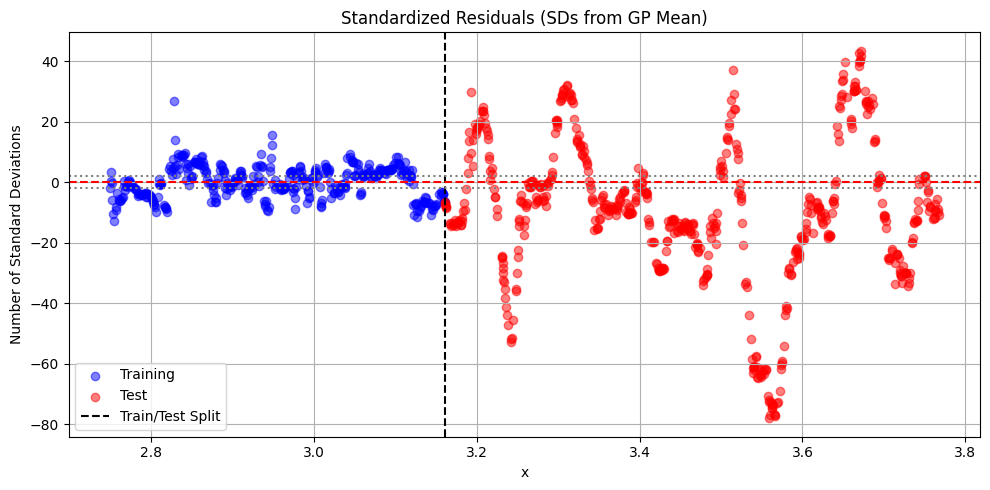

In [88]:
with torch.no_grad():
    # Get posterior mean and standard deviation
    posterior = model(x_standardized)
    mean = posterior.mean * y_std + y_mean
    variance = posterior.variance * (y_std ** 2)
    std = torch.sqrt(variance)
    
    # Calculate standardized residuals
    residuals = (y - mean) / std

# Plot standardized residuals
plt.figure(figsize=(10, 5))

# Training and test residuals in different colors
plt.scatter(x[:n_train].numpy(), residuals[:n_train].numpy(), c='blue', alpha=0.5, label='Training')
plt.scatter(x[n_train:].numpy(), residuals[n_train:].numpy(), c='red', alpha=0.5, label='Test')

# Add vertical line at train/test split
plt.axvline(x=x[n_train].numpy(), color='k', linestyle='--', label='Train/Test Split')

# Add horizontal reference lines for ±2 SDs
plt.axhline(y=0, color='r', linestyle='--')
plt.axhline(y=2, color='gray', linestyle=':')
plt.axhline(y=-2, color='gray', linestyle=':')

# Labels and formatting
plt.title('Standardized Residuals (SDs from GP Mean)')
plt.xlabel('x')
plt.ylabel('Number of Standard Deviations')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


- Idea: maybe have higher uncertainty for the bubbles?
-shoudl have higher uncertainty overall. 
- there should be a higher amount of uncertainty as time goes on.
- i am not sure if the kernel is correctly fitted at the beginning